In [1]:
from itertools import product
import matplotlib.pyplot as plt
from model import model_fn
import numpy as np
import skopt
import tensorflow as tf
import utils
%matplotlib inline

c:\users\smmeenehan\appdata\local\programs\python\python36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


Run the cell below if you don't want endless amounts of output from the train/eval loop. We're going to monitor things in TensorBoard anyway.

In [2]:
tf.logging.set_verbosity(tf.logging.WARN)

In [3]:
_, data_format = utils.device_and_data_format()
batch_size = 64
shuffle = 1000
train, val, test, x_test_raw = utils.get_CIFAR10_data(data_format, batch_size=batch_size, shuffle=shuffle)
train_input_fn = lambda: train.make_one_shot_iterator().get_next()
val_input_fn = lambda: val.make_one_shot_iterator().get_next()
test_input_fn = lambda: test.make_one_shot_iterator().get_next()

In [5]:
def train_eval_loop(log_dir, num_epochs, params):
    """Basic train-evaluate loop. Builds an estimator and logs validation
    accuracy after every epoch. 

    Parameters
    ----------
    model_fn : function
        Estimator model function
    log_dir : string
        Directory in which to log event files and Estimator checkpoints 
    num_epochs : int
        Number of epochs to run the loop
    params : dictionary
        Dictionary of hyper-parameters to use in the Estimator

    Returns
    -------
    float
        Best validation accuracy seen during the loop.
    """
    estimator = tf.estimator.Estimator(
        model_fn, model_dir=log_dir, params=params, 
        config=tf.estimator.RunConfig(keep_checkpoint_max=1))
    best_accuracy = 0
    for idx in range(num_epochs):
        estimator.train(val_input_fn)
        metric_dict = estimator.evaluate(val_input_fn)
        accuracy = metric_dict['accuracy']
        if accuracy > best_accuracy:
            best_accuracy = accuracy
    return accuracy

In [6]:
def log_dir_name(log_dir_root, optim_type, learning_rate, reg_scale, momentum=None):
    log_dir = log_dir_root+'/'+optim_type+'/'
    log_dir += 'lr_%.3g_reg_%.3g' % (learning_rate, reg_scale)
    if optim_type is 'Momentum':
        if momentum is None:
            raise ValueError('Must specify momentum when using optim_type = \'Momentum\'')
        log_dir += '_mom_%.2g' % momentum
    return log_dir

In [7]:
def fitness_Adam(x):
    learning_rate, reg_scale = x
    log_dir = log_dir_name('logs', 'Adam', learning_rate, reg_scale)
    params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, \
              'optim_type': 'Adam', 'data_format': data_format, \
              'model_dir': log_dir}
    try:
        status_str = 'lr = %.3g, reg = %.3g : ' % (learning_rate, reg_scale)
        print(status_str, end='')
        accuracy = train_eval_loop(log_dir, 1, params)
        print(accuracy)
        return -accuracy
    except:
        print('fail')
        return 10
    
def fitness_Momentum(x):
    learning_rate, reg_scale, momentum = x
    log_dir = log_dir_name('logs', 'Momentum', learning_rate, reg_scale, momentum)
    params = {'learning_rate': learning_rate, 'reg_scale': reg_scale, \
              'optim_type': 'Momentum', 'data_format': data_format, \
              'momentum': momentum, 'model_dir': log_dir}
    try:
        status_str = 'lr = %.3g, reg = %.3g, mom = %.2g : ' % (learning_rate, reg_scale, momentum)
        print(status_str, end='')
        accuracy = train_eval_loop(log_dir, 1, params)
        print(accuracy)
        return -accuracy
    except:
        print('fail')
        return 10

In [8]:
dimensions_Adam = [skopt.space.Real(1e-4, 1e-2, 'log-uniform', name='learning_rate'),
                   skopt.space.Real(1e-4, 1e-2, name='reg_scale')]
default_Adam = [0.002, 0.005]

dimensions_Momentum = [skopt.space.Real(1e-6, 1e-2, 'log-uniform', name='learning_rate'),
                       skopt.space.Real(1e-4, 1e-2, name='reg_scale'),
                       skopt.space.Real(0.8, 0.95, name='momentum')]
default_Momentum = [0.001, 0.005, 0.9]

In [10]:
search_result  = skopt.gp_minimize(func=fitness_Adam,
                                   dimensions=dimensions_Adam,
                                   acq_func='EI', # Expected Improvement.
                                   n_calls=25,
                                   x0=default_Adam)

lr = 0.002, reg = 0.005 : 0.14
lr = 0.00153, reg = 0.00327 : 0.177
lr = 0.00311, reg = 0.00113 : 0.146
lr = 0.000107, reg = 0.00552 : 0.129
lr = 0.00112, reg = 0.00885 : 0.143
lr = 0.000953, reg = 0.0015 : 0.143
lr = 0.00139, reg = 0.00444 : 0.186
lr = 0.000626, reg = 0.00873 : 0.21
lr = 0.00195, reg = 0.00216 : 0.176
lr = 0.00225, reg = 0.00533 : 0.139
lr = 0.000383, reg = 0.00285 : 0.168
lr = 0.0001, reg = 0.00985 : 0.128
lr = 0.00993, reg = 0.000146 : 0.124
lr = 0.000105, reg = 0.01 : 0.175
lr = 0.01, reg = 0.00983 : 0.098
lr = 0.0001, reg = 0.000129 : 0.114
lr = 0.000433, reg = 0.00994 : 0.181
lr = 0.000449, reg = 0.000103 : 0.161
lr = 0.000486, reg = 0.00998 : 0.17
lr = 0.000415, reg = 0.00999 : 0.187
lr = 0.000441, reg = 0.00999 : 0.191
lr = 0.000703, reg = 0.00998 : 0.192
lr = 0.000322, reg = 0.00999 : 0.193
lr = 0.000558, reg = 0.000129 : 0.203
lr = 0.000436, reg = 0.000109 : 0.177


In [12]:
search_result.x

[0.0006263158030885172, 0.008726667015999732]

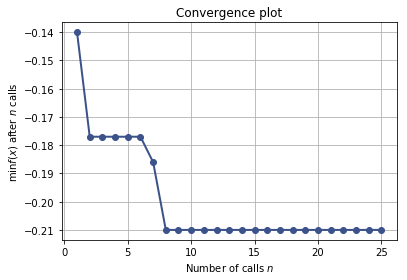

In [17]:
skopt.plots.plot_convergence(search_result)

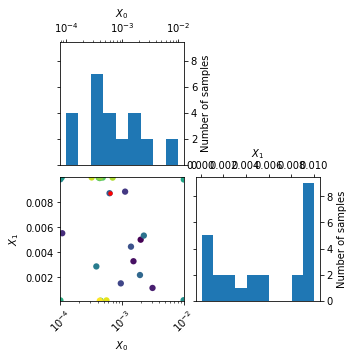

In [21]:
_ = skopt.plots.plot_evaluations(search_result, bins=10)

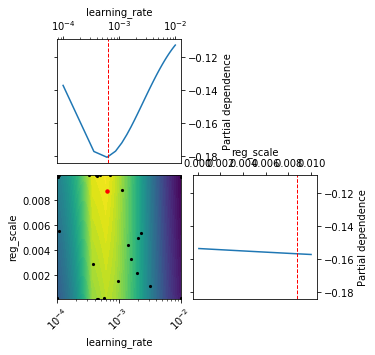

In [16]:
fig = skopt.plots.plot_objective(result=search_result, dimensions=['learning_rate', 'reg_scale'], levels=50)